# Advanced RAG configuration with LangChain

- Author: Martin Fockedey with the help of copilot


## Environment Setup

In [ ]:
%pip install -q python-dotenv langchain_mistralai langchain_text_splitters langchain_community langchain_core faiss-cpu pymupdf rank_bm25 pandas matplotlib seaborn

In [2]:
# Load environment variables (expects MISTRAL_API_KEY in .env)
from dotenv import load_dotenv
load_dotenv(override=True)

True

## Benchmark Dataset: Student Questions

We create a comprehensive set of questions covering all administrative topics that students commonly ask about.

In [ ]:
# Benchmark questions organized by topic
benchmark_questions = {
    "inscription": [
        "Quelles sont les conditions d'admission pour un étudiant belge en BAC1?",
        "Un étudiant étranger hors UE peut-il s'inscrire directement à ECAM?",
        "Quels documents sont nécessaires pour l'inscription?",
    ],
    "financabilité": [
        "Qu'est-ce que la financabilité d'un étudiant?",
        "Combien d'années un étudiant peut-il échouer avant de perdre sa financabilité?",
        "Comment un étudiant peut-il récupérer sa financabilité?",
        "Suis-je financable si j'ai déjà fait 3 années dans une autre école?",
    ],
    "frais": [
        "Quels sont les frais d'inscription à ECAM?",
        "Y a-t-il des réductions pour les étudiants boursiers?",
        "Que se passe-t-il si je ne paie pas mes frais d'inscription à temps?",
    ],
    "medical": [
        "Est-ce qu'un bilan médical est obligatoire pour tous les étudiants?",
        "Quand doit-on effectuer le bilan médical?",
    ],
    "programme": [
        "Comment créer mon programme d'étude personnalisé?",
        "Puis-je choisir moins de 60 crédits par an?",
        "Qu'est-ce qu'une Activité d'Apprentissage (AA)?",
        "Qu'est-ce qu'une Unité d'Enseignement (UE)?",
        "Quelle est la différence entre une AA et une UE?",
    ],
    "international": [
        "Quelles sont les opportunités d'échange international à ECAM?",
        "Comment postuler pour un programme Erasmus?",
        "Les crédits obtenus à l'étranger sont-ils reconnus?",
    ],
    "calendrier": [
        "Quand commencent les cours au premier quadrimestre?",
        "Quelles sont les dates de la session d'examens de janvier?",
        "Y a-t-il une session d'examens en septembre?",
    ],
    "besoins_specifiques": [
        "Quelles aides sont disponibles pour les étudiants à besoins spécifiques?",
        "Comment demander un aménagement pour un handicap?",
        "Existe-t-il un service d'aide à la réussite?",
    ],
    "plagiat": [
        "Quelle est la définition du plagiat académique?",
        "Quelles sont les sanctions pour le plagiat?",
        "Comment éviter le plagiat dans mes travaux?",
        "Que se passe-t-il si je suis accusé de fraude à un examen?",
    ],
    "jury": [
        "Qu'est-ce qu'un jury de délibération?",
        "Comment sont prises les décisions du jury?",
        "Puis-je contester une décision du jury?",
        "Qui compose le jury d'examen?",
    ],
}

# Flatten all questions into a single list
all_questions = [q for topic_questions in benchmark_questions.values() for q in topic_questions]
print(f"Total benchmark questions: {len(all_questions)}")
print("\nSample questions:")
for i, q in enumerate(all_questions[:5], 1):
    print(f"{i}. {q}")

Total benchmark questions: 34

Sample questions:
1. Quelles sont les conditions d'admission pour un étudiant belge en BAC1?
2. Un étudiant étranger hors UE peut-il s'inscrire directement à ECAM?
3. Quels documents sont nécessaires pour l'inscription?
4. Qu'est-ce que la financabilité d'un étudiant?
5. Combien d'années un étudiant peut-il échouer avant de perdre sa financabilité?


## Load & Prepare Document

We load the ECAM regulation PDF and split it into chunks using the RecursiveTextSplitter as in notebook 08.

In [4]:
from langchain_community.document_loaders import PyMuPDFLoader
import os

PDF_PATH = 'RéglementECAM.pdf'
assert os.path.exists(PDF_PATH), f'File not found: {PDF_PATH}'

loader = PyMuPDFLoader(PDF_PATH)
docs = loader.load()
print(f"Loaded {len(docs)} pages from PDF")

Loaded 61 pages from PDF


In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

custom_separators = [
    "\n \n",      # paragraphs
    "\n",         # lines
    ". ",         # sentence boundary
    "; ",         # clause boundary
    ", ",         # phrase boundary
    " ",          # words
    ""            # fallback: characters
]

text_splitter = RecursiveCharacterTextSplitter(
    separators=custom_separators,
    chunk_size=1000,
    chunk_overlap=80
)

split_docs = text_splitter.split_documents(docs)
print(f"Split into {len(split_docs)} chunks")

Split into 316 chunks


## Create Vector Store

We create embeddings using Mistral and build a FAISS vector store (reusing from notebook 08 if available).

In [6]:
from langchain_mistralai import MistralAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = MistralAIEmbeddings(model='mistral-embed')

STORE_DIR = 'faiss_store'
if os.path.isdir(STORE_DIR):
    print('Loading existing FAISS store...')
    vectorstore = FAISS.load_local(STORE_DIR, embeddings, allow_dangerous_deserialization=True)
else:
    print('Creating new FAISS store and saving...')
    vectorstore = FAISS.from_documents(split_docs, embeddings)
    vectorstore.save_local(STORE_DIR)
    
print("Vector store ready!")

Loading existing FAISS store...
Vector store ready!


## Configuration 1: Simple Prompt (No RAG)

This configuration uses only the LLM without any retrieval. The model answers based on its training data.

In [12]:
from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatMistralAI(model="mistral-small-latest", temperature=0)

simple_prompt = PromptTemplate.from_template(
    """Tu es un assistant qui répond aux questions sur ECAM, une école d'ingénieurs en Belgique.
Réponds de manière concise et factuelle.

Question: {question}

Réponse:"""
)

simple_chain = simple_prompt | llm | StrOutputParser()

def ask_simple(question: str) -> str:
    """Ask without RAG - relies on model's training data."""
    return simple_chain.invoke({"question": question})

# Test
test_q = "Qu'est-ce que la financabilité d'un étudiant?"
print(f"Q: {test_q}")
print(f"A: {ask_simple(test_q)}")

Q: Qu'est-ce que la financabilité d'un étudiant?
A: La **financabilité** d'un étudiant à l'ECAM (ou dans d'autres écoles) désigne sa capacité à couvrir les frais de scolarité et les coûts liés à ses études. Cela inclut :

- **Bourses** (ex. : bourses d'excellence, aides sociales)
- **Prêts étudiants** (via des institutions comme la Région wallonne)
- **Emplois étudiants** (temps partiel)
- **Aides familiales** ou autres sources de financement.

L'ECAM propose des solutions pour faciliter l'accès aux études, comme des bourses ou des facilités de paiement.
A: La **financabilité** d'un étudiant à l'ECAM (ou dans d'autres écoles) désigne sa capacité à couvrir les frais de scolarité et les coûts liés à ses études. Cela inclut :

- **Bourses** (ex. : bourses d'excellence, aides sociales)
- **Prêts étudiants** (via des institutions comme la Région wallonne)
- **Emplois étudiants** (temps partiel)
- **Aides familiales** ou autres sources de financement.

L'ECAM propose des solutions pour facil

## Configuration 2: Basic RAG (Similarity Retrieval)

This configuration uses simple similarity-based retrieval with the top-k most similar chunks.

In [8]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(f"[Page {d.metadata.get('page','N/A')}] {d.page_content}" for d in docs)

basic_retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 4})

basic_rag_prompt = PromptTemplate.from_template(
    """Tu es un Assistant Scolaire ECAM répondant aux questions sur le règlement interne.

CONTRAINTES:
1. Utilise UNIQUEMENT le contexte fourni du règlement interne.
2. Cite chaque fait avec la page sous forme [Page X].
3. Ne fabrique rien.
4. Si l'information n'est pas dans le contexte, dis "Je ne sais pas sur base du contexte fourni."

Format attendu:
Réponse concise en français.

Question: {question}

Contexte:
{context}

Réponse:"""
)

basic_rag_chain = (
    {"context": basic_retriever | format_docs, "question": RunnablePassthrough()} 
    | basic_rag_prompt
    | llm
    | StrOutputParser()
)

def ask_basic_rag(question: str) -> str:
    """Ask using basic RAG with similarity retrieval."""
    return basic_rag_chain.invoke(question)

# Test
print(f"Q: {test_q}")
print(f"A: {ask_basic_rag(test_q)}")

Q: Qu'est-ce que la financabilité?
A: La financabilité désigne l'éligibilité d'un étudiant à bénéficier d'une aide financière de la Fédération Wallonie-Bruxelles, en fonction de son parcours académique. Elle est évaluée individuellement et dépend de critères comme la réussite académique, les réorientations ou l'acquisition de crédits [Page 10]. Les étudiants peuvent vérifier leur finançabilité via un outil en ligne (https://mesetudes.be/financabilite/formulaire) [Page 10]. En cas de non-finançabilité, l'établissement peut demander une demande motivée [Page 11].
A: La financabilité désigne l'éligibilité d'un étudiant à bénéficier d'une aide financière de la Fédération Wallonie-Bruxelles, en fonction de son parcours académique. Elle est évaluée individuellement et dépend de critères comme la réussite académique, les réorientations ou l'acquisition de crédits [Page 10]. Les étudiants peuvent vérifier leur finançabilité via un outil en ligne (https://mesetudes.be/financabilite/formulaire) 

## Configuration 3: Advanced RAG (Ensemble Retrieval)

This configuration combines BM25 (lexical) and dense (semantic) retrieval for better results, especially for specific terms and names.

In [9]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever

# Prepare BM25 retriever
texts_for_bm25 = [d.page_content for d in split_docs]
bm25 = BM25Retriever.from_texts(texts_for_bm25, metadatas=[d.metadata for d in split_docs])
bm25.k = 4

# Dense retriever
dense_retriever = vectorstore.as_retriever(search_kwargs={'k': 4})

# Combine with ensemble (60% BM25, 40% dense for keyword-heavy queries)
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25, dense_retriever], 
    weights=[0.6, 0.4]
)

advanced_rag_prompt = PromptTemplate.from_template(
    """Tu es un Assistant Scolaire ECAM répondant aux questions sur le règlement interne.

CONTRAINTES:
1. Utilise UNIQUEMENT le contexte fourni du règlement interne.
2. Cite chaque fait avec la page sous forme [Page X].
3. Ne fabrique rien.
4. Si l'information n'est pas dans le contexte, dis "Je ne sais pas sur base du contexte fourni."

Format attendu:
Réponse concise en français avec citations.
CITES: Page: X,Y,... (liste unique de pages utilisées)

Question: {question}

Contexte:
{context}

Réponse:"""
)

advanced_rag_chain = (
    {"context": ensemble_retriever | format_docs, "question": RunnablePassthrough()} 
    | advanced_rag_prompt
    | llm
    | StrOutputParser()
)

def ask_advanced_rag(question: str) -> str:
    """Ask using advanced RAG with ensemble retrieval."""
    return advanced_rag_chain.invoke(question)

# Test
print(f"Q: {test_q}")
print(f"A: {ask_advanced_rag(test_q)}")

Q: Qu'est-ce que la financabilité?
A: La **finançabilité** désigne le droit pour un·e étudiant·e d'être financé·e par la Fédération Wallonie-Bruxelles pour ses études supérieures, sous réserve de respecter certaines conditions académiques. Elle est évaluée en fonction du parcours individuel de l'étudiant·e, notamment ses résultats, réorientations ou crédits acquis [Page 10, 11].

Pour vérifier sa finançabilité, l'étudiant·e peut consulter la page interactive de la Fédération Wallonie-Bruxelles [Page 10]. En cas de non-finançabilité, l'établissement l'informe et lui demande de motiver sa demande d'inscription [Page 11].

CITES: Page: 10, 11
A: La **finançabilité** désigne le droit pour un·e étudiant·e d'être financé·e par la Fédération Wallonie-Bruxelles pour ses études supérieures, sous réserve de respecter certaines conditions académiques. Elle est évaluée en fonction du parcours individuel de l'étudiant·e, notamment ses résultats, réorientations ou crédits acquis [Page 10, 11].

Pour

## Generate Reference Answers

We use the advanced RAG configuration to generate reference answers for our benchmark questions. These will serve as the "ground truth" for evaluation. **THIS IS A BAD PRACTICE AS THE GROUNDTRUTH HERE WILL PROPABBLY CONTAIN ERRORS BUT I DON'T HAVE TIME TO WRITE EVERYTHING BY HAND**

In [ ]:
import time

print("Generating reference answers using Advanced RAG...")
print("This may take a Some time...\n")

reference_answers = {}
for i, question in enumerate(all_questions, 1):
    print(f"[{i}/{len(all_questions)}] {question[:60]}...")
    reference_answers[question] = ask_advanced_rag(question)
    time.sleep(0.5)  # Rate limiting

print("\n✓ Reference answers generated!")
print(f"Total: {len(reference_answers)} Q&A pairs")

Generating reference answers using Advanced RAG...
This may take a few minutes...

[1/34] Quelles sont les conditions d'admission pour un étudiant bel...
[2/34] Un étudiant étranger hors UE peut-il s'inscrire directement ...
[2/34] Un étudiant étranger hors UE peut-il s'inscrire directement ...
[3/34] Quels documents sont nécessaires pour l'inscription?...
[3/34] Quels documents sont nécessaires pour l'inscription?...
[4/34] Qu'est-ce que la financabilité d'un étudiant?...
[4/34] Qu'est-ce que la financabilité d'un étudiant?...
[5/34] Combien d'années un étudiant peut-il échouer avant de perdre...
[5/34] Combien d'années un étudiant peut-il échouer avant de perdre...
[6/34] Comment un étudiant peut-il récupérer sa financabilité?...
[6/34] Comment un étudiant peut-il récupérer sa financabilité?...
[7/34] Suis-je financable si j'ai déjà fait 3 années dans une autre...
[7/34] Suis-je financable si j'ai déjà fait 3 années dans une autre...
[8/34] Quels sont les frais d'inscription à ECAM?.

## AI as a Judge: Evaluation System

We create an LLM-based judge that evaluates RAG responses by comparing them with reference answers on multiple criteria:
- **Accuracy**: How factually correct is the response?
- **Completeness**: Does it cover all key points?
- **Citation Quality**: Are sources properly cited?
- **Relevance**: Does it address the question?

The judge returns scores from 1-5 for each criterion plus an overall score.

In [13]:
import json
import re

judge_prompt = PromptTemplate.from_template(
    """Tu es un évaluateur expert de systèmes de questions-réponses.
Évalue la RÉPONSE CANDIDATE en la comparant à la RÉPONSE DE RÉFÉRENCE.

QUESTION: {question}

RÉPONSE DE RÉFÉRENCE (ground truth):
{reference_answer}

RÉPONSE CANDIDATE (à évaluer):
{candidate_answer}

CRITÈRES D'ÉVALUATION (note de 1 à 5):
1. ACCURACY (exactitude): Les faits sont-ils corrects?
2. COMPLETENESS (complétude): Tous les points importants sont-ils couverts?
3. CITATION_QUALITY (qualité des citations): Les sources sont-elles bien citées?
4. RELEVANCE (pertinence): La réponse est-elle pertinente pour la question?

INSTRUCTIONS:
- Note chaque critère de 1 (très mauvais) à 5 (excellent)
- Donne une note globale (OVERALL) de 1 à 5
- Fournis une brève justification

FORMAT DE RÉPONSE: Réponds UNIQUEMENT avec un objet JSON valide (sans markdown):
{{
    "accuracy": <score>,
    "completeness": <score>,
    "citation_quality": <score>,
    "relevance": <score>,
    "overall": <score>,
    "justification": "<ton explication en 2-3 phrases>"
}}
"""
)

judge_llm = ChatMistralAI(model="mistral-small-latest", temperature=0)
judge_chain = judge_prompt | judge_llm | StrOutputParser()

def parse_judge_scores(judge_output: str) -> dict:
    """Parse judge output to extract scores from JSON."""
    try:
        # Try to parse as JSON directly
        scores = json.loads(judge_output)
        # Ensure all required keys exist with default values
        default_scores = {
            'accuracy': 0,
            'completeness': 0,
            'citation_quality': 0,
            'relevance': 0,
            'overall': 0,
            'justification': ''
        }
        default_scores.update(scores)
        return default_scores
    except json.JSONDecodeError:
        # Fallback: try to extract JSON from markdown code blocks
        json_match = re.search(r'```(?:json)?\s*(\{.*?\})\s*```', judge_output, re.DOTALL)
        if json_match:
            try:
                scores = json.loads(json_match.group(1))
                default_scores = {
                    'accuracy': 0,
                    'completeness': 0,
                    'citation_quality': 0,
                    'relevance': 0,
                    'overall': 0,
                    'justification': ''
                }
                default_scores.update(scores)
                return default_scores
            except json.JSONDecodeError:
                pass
        
        # Return default scores if parsing fails
        return {
            'accuracy': 0,
            'completeness': 0,
            'citation_quality': 0,
            'relevance': 0,
            'overall': 0,
            'justification': 'Error parsing judge output'
        }

def evaluate_answer(question: str, reference_answer: str, candidate_answer: str) -> dict:
    """Evaluate a candidate answer against a reference answer."""
    judge_output = judge_chain.invoke({
        "question": question,
        "reference_answer": reference_answer,
        "candidate_answer": candidate_answer
    })
    return parse_judge_scores(judge_output)

# Test the judge
test_evaluation = evaluate_answer(
    test_q,
    reference_answers[test_q],
    ask_basic_rag(test_q)
)
print("Test evaluation:")
for key, value in test_evaluation.items():
    print(f"  {key}: {value}")

Test evaluation:
  accuracy: 4
  completeness: 3
  citation_quality: 4
  relevance: 4
  overall: 4
  justification: La réponse candidate est globalement correcte et pertinente, mais elle manque de détails sur les critères académiques et administratifs mentionnés dans la référence. Les citations sont bien utilisées, mais la complétude est limitée par l'absence de certains points clés.


## Run Complete Evaluation

We now evaluate all three configurations on our benchmark questions.

In [14]:
import pandas as pd

print("Running complete evaluation...")
print("This will take several minutes...\n")

results = []

configurations = {
    'Simple Prompt': ask_simple,
    'Basic RAG': ask_basic_rag,
    'Advanced RAG': ask_advanced_rag
}

total_evals = len(all_questions) * len(configurations)
current_eval = 0

for question in all_questions:
    reference = reference_answers[question]
    
    # Find topic
    topic = 'other'
    for t, qs in benchmark_questions.items():
        if question in qs:
            topic = t
            break
    
    for config_name, ask_func in configurations.items():
        current_eval += 1
        print(f"[{current_eval}/{total_evals}] {config_name}: {question[:50]}...")
        
        try:
            # Generate answer
            candidate = ask_func(question)
            
            # Evaluate
            scores = evaluate_answer(question, reference, candidate)
            
            # Store results
            results.append({
                'question': question,
                'topic': topic,
                'configuration': config_name,
                'reference_answer': reference,
                'candidate_answer': candidate,
                **scores
            })
            
            time.sleep(0.5)  # Rate limiting
        except Exception as e:
            print(f"  ERROR: {e}")
            results.append({
                'question': question,
                'topic': topic,
                'configuration': config_name,
                'reference_answer': reference,
                'candidate_answer': f"ERROR: {str(e)}",
                'accuracy': 0,
                'completeness': 0,
                'citation_quality': 0,
                'relevance': 0,
                'overall': 0,
                'justification': f"Error: {str(e)}"
            })

# Create DataFrame
df_results = pd.DataFrame(results)
print("\n✓ Evaluation complete!")
print(f"Total evaluations: {len(df_results)}")

Running complete evaluation...
This will take several minutes...

[1/102] Simple Prompt: Quelles sont les conditions d'admission pour un ét...
[2/102] Basic RAG: Quelles sont les conditions d'admission pour un ét...
[2/102] Basic RAG: Quelles sont les conditions d'admission pour un ét...
[3/102] Advanced RAG: Quelles sont les conditions d'admission pour un ét...
[3/102] Advanced RAG: Quelles sont les conditions d'admission pour un ét...
[4/102] Simple Prompt: Un étudiant étranger hors UE peut-il s'inscrire di...
[4/102] Simple Prompt: Un étudiant étranger hors UE peut-il s'inscrire di...
[5/102] Basic RAG: Un étudiant étranger hors UE peut-il s'inscrire di...
[5/102] Basic RAG: Un étudiant étranger hors UE peut-il s'inscrire di...
[6/102] Advanced RAG: Un étudiant étranger hors UE peut-il s'inscrire di...
[6/102] Advanced RAG: Un étudiant étranger hors UE peut-il s'inscrire di...
[7/102] Simple Prompt: Quels documents sont nécessaires pour l'inscriptio...
[7/102] Simple Prompt: Quels d

## Analysis: Overall Performance

In [ ]:
# Overall statistics by configuration
print("="*60)
print("OVERALL PERFORMANCE BY CONFIGURATION")
print("="*60)

summary = df_results.groupby('configuration')[['accuracy', 'completeness', 'citation_quality', 'relevance', 'overall']].mean()
print(summary.round(2))
print("\n")

# Best configuration overall
best_config = summary['overall'].idxmax()
best_score = summary['overall'].max()
print(f"Best Configuration: {best_config} (Overall Score: {best_score:.2f})")

OVERALL PERFORMANCE BY CONFIGURATION
               accuracy  completeness  citation_quality  relevance  overall
configuration                                                              
Advanced RAG       4.68          4.71              4.56       4.85     4.62
Basic RAG          4.03          3.68              4.06       4.26     3.79
Simple Prompt      3.44          3.09              1.74       4.18     2.94


🏆 Best Configuration: Advanced RAG (Overall Score: 4.62)


The best performance from the advanced RAG was to be expected as it was the one use as ground truth. But can you explain why the score is not of 5 if the responses come from the same tool?

## Analysis: Performance by Topic

In [16]:
print("="*60)
print("PERFORMANCE BY TOPIC")
print("="*60)

topic_summary = df_results.pivot_table(
    values='overall', 
    index='topic', 
    columns='configuration',
    aggfunc='mean'
)
print(topic_summary.round(2))
print("\n")

# Topics where each configuration excels
print("Topics where each configuration performs best:")
for config in configurations.keys():
    best_topics = topic_summary[topic_summary[config] == topic_summary.max(axis=1)].index.tolist()
    if best_topics:
        print(f"  {config}: {', '.join(best_topics)}")

PERFORMANCE BY TOPIC
configuration        Advanced RAG  Basic RAG  Simple Prompt
topic                                                      
besoins_specifiques          4.67       3.33           3.00
calendrier                   4.33       4.00           3.00
financabilité                4.75       3.50           3.00
frais                        5.00       3.67           3.00
inscription                  5.00       3.67           3.00
international                3.33       2.67           3.33
jury                         4.75       4.75           2.50
medical                      5.00       5.00           2.00
plagiat                      4.50       4.00           3.50
programme                    4.80       3.60           2.80


Topics where each configuration performs best:
  Simple Prompt: international
  Basic RAG: jury, medical
  Advanced RAG: besoins_specifiques, calendrier, financabilité, frais, inscription, international, jury, medical, plagiat, programme


## Visualizations

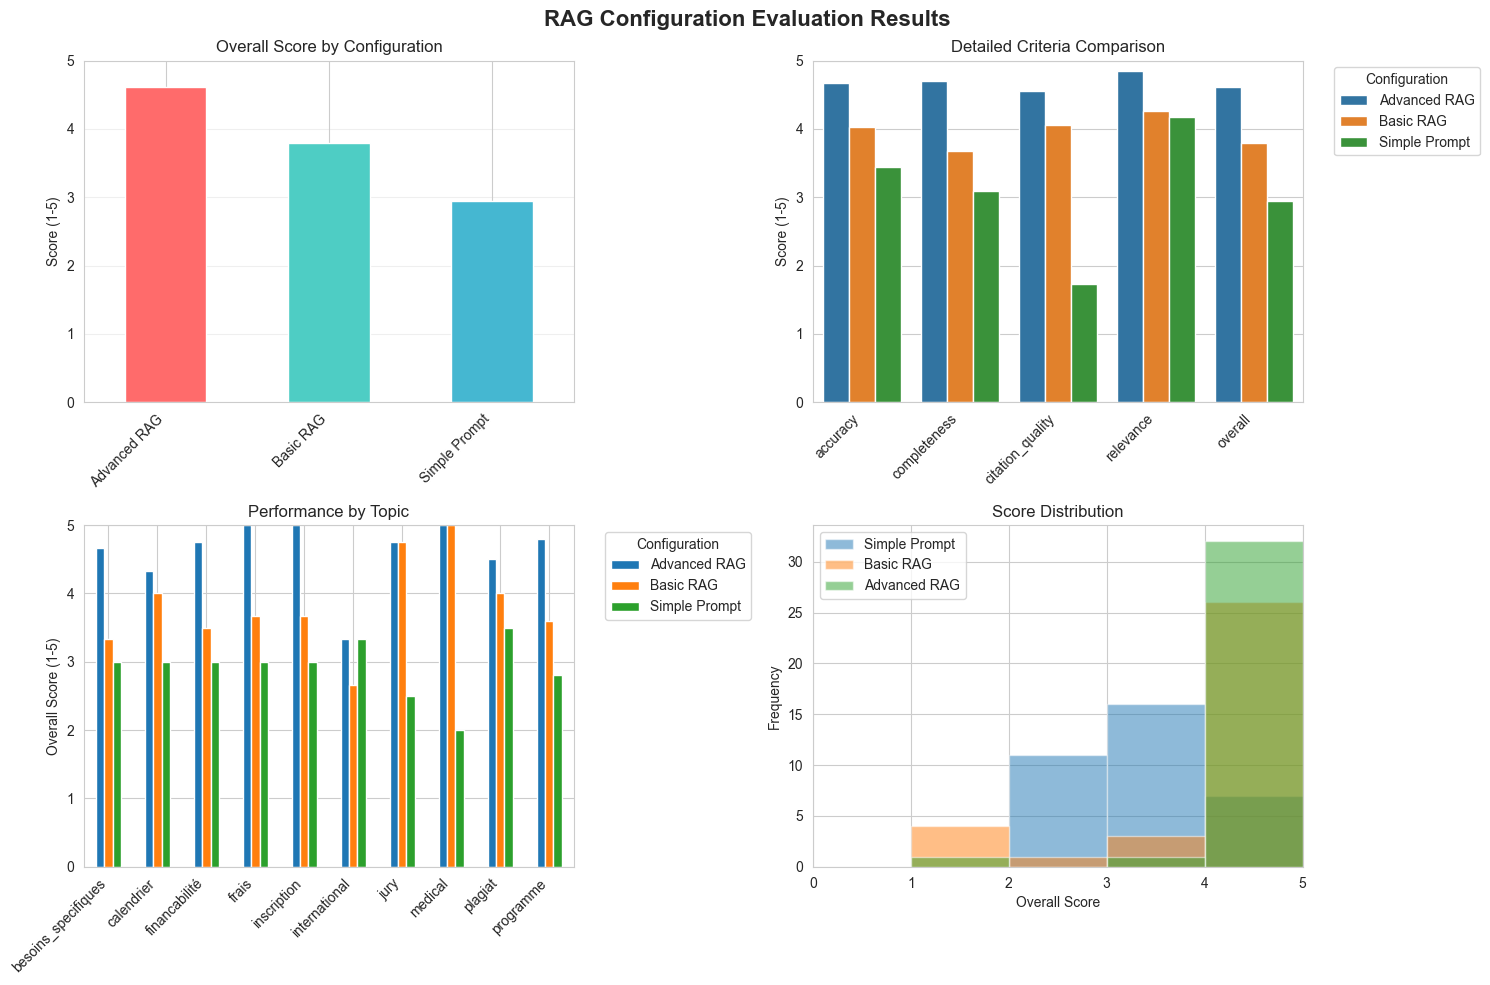

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Overall scores comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('RAG Configuration Evaluation Results', fontsize=16, fontweight='bold')

# Overall score by configuration
ax1 = axes[0, 0]
summary['overall'].plot(kind='bar', ax=ax1, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Overall Score by Configuration')
ax1.set_ylabel('Score (1-5)')
ax1.set_xlabel('')
ax1.set_ylim(0, 5)
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# All criteria comparison
ax2 = axes[0, 1]
summary_melted = summary.reset_index().melt(id_vars='configuration', 
                                             var_name='criterion', 
                                             value_name='score')
sns.barplot(data=summary_melted, x='criterion', y='score', hue='configuration', ax=ax2)
ax2.set_title('Detailed Criteria Comparison')
ax2.set_ylabel('Score (1-5)')
ax2.set_xlabel('')
ax2.set_ylim(0, 5)
ax2.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Performance by topic
ax3 = axes[1, 0]
topic_summary.plot(kind='bar', ax=ax3)
ax3.set_title('Performance by Topic')
ax3.set_ylabel('Overall Score (1-5)')
ax3.set_xlabel('')
ax3.set_ylim(0, 5)
ax3.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Score distribution
ax4 = axes[1, 1]
for config in configurations.keys():
    config_data = df_results[df_results['configuration'] == config]['overall']
    ax4.hist(config_data, alpha=0.5, label=config, bins=5, range=(0, 5))
ax4.set_title('Score Distribution')
ax4.set_xlabel('Overall Score')
ax4.set_ylabel('Frequency')
ax4.legend()
ax4.set_xlim(0, 5)

plt.tight_layout()
plt.show()

## Detailed Examples: Worst Cases

Analyzing and checking worst Cases can help us to understand what are the cause for erros and mistakes and ways to improve the prompt and the configuration.

In [ ]:
print("="*60)
print("WORST PERFORMING EXAMPLES (Areas for Improvement)")
print("="*60)

for config in configurations.keys():
    config_df = df_results[df_results['configuration'] == config]
    worst = config_df.nsmallest(1, 'overall').iloc[0]
    
    print(f"\n{'='*60}")
    print(f"Configuration: {config}")
    print(f"Score: {worst['overall']:.1f}/5")
    print(f"{'='*60}")
    print(f"\nQuestion: {worst['question']}")
    print(f"\nAnswer: {worst['candidate_answer'][:300]}...")
    print(f"\nJustification: {worst['justification']}")

## Interactive Testing

Test any question with all three configurations side-by-side.

In [19]:
def compare_all_configs(question: str):
    """Compare responses from all configurations for a given question."""
    print("="*80)
    print(f"Question: {question}")
    print("="*80)
    
    for config_name, ask_func in configurations.items():
        print(f"\n{'─'*80}")
        print(f"Configuration: {config_name}")
        print(f"{'─'*80}")
        answer = ask_func(question)
        print(answer)
        print()

# Try it out!
compare_all_configs("Comment puis-je contester une décision du jury?")

Question: Comment puis-je contester une décision du jury?

────────────────────────────────────────────────────────────────────────────────
Configuration: Simple Prompt
────────────────────────────────────────────────────────────────────────────────
Pour contester une décision du jury à l'ECAM, voici la procédure à suivre :

1. **Délai** : Vous disposez généralement de **15 jours ouvrables** à partir de la notification de la décision pour introduire un recours.
2. **Formulaire** : Remplissez le formulaire de recours disponible auprès du secrétariat académique ou sur le site de l'école.
3. **Motivation** : Joignez une lettre expliquant les motifs de votre contestation (erreur de procédure, manque de preuves, etc.).
4. **Envoi** : Adressez le dossier au **jury d'appel** (composé de membres différents du jury initial) via le secrétariat académique.
5. **Décision** : Le jury d'appel statue dans un délai défini (souvent 30 jours).

*Conseil* : Consultez le **Règlement des études** de l'ECAM

In [20]:
# Test with your own question
your_question = "Puis-je partir en Erasmus si j'ai échoué une année?"
compare_all_configs(your_question)

Question: Puis-je partir en Erasmus si j'ai échoué une année?

────────────────────────────────────────────────────────────────────────────────
Configuration: Simple Prompt
────────────────────────────────────────────────────────────────────────────────
Oui, il est possible de partir en Erasmus même après un échec, mais sous certaines conditions. L'école (ECAM) évalue généralement la situation au cas par cas. Il faut avoir validé un certain nombre de crédits et obtenir l'accord de l'administration. Contactez le service des relations internationales d'ECAM pour plus de détails.


────────────────────────────────────────────────────────────────────────────────
Configuration: Basic RAG
────────────────────────────────────────────────────────────────────────────────
Oui, il est possible de partir en Erasmus même après un échec, mais sous certaines conditions. L'école (ECAM) évalue généralement la situation au cas par cas. Il faut avoir validé un certain nombre de crédits et obtenir l'accor